In [133]:
%matplotlib inline
from hamiltonian.games import QuadraticGame
from hamiltonian.games.utils import make_sym_matrix
from hamiltonian.algorithms import SEG
from hamiltonian.algorithms.lr_scheduler import LRScheduler
import torch
from dataclasses import dataclass
from omegaconf import MISSING
from typing import Union, Optional
from enum import Enum, auto
import math
import uuid
import glob
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
import random
import importlib

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})

width = 487.8225
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

In [121]:
class SEGScheduler(LRScheduler):
    def __init__(self, K, rho, lr, L_i=None, importance_sampling=False):
        super().__init__(lr)
        self.K = K
        self.rho = rho
        self.k_0 = math.ceil(self.K/2)
        self.importance_sampling = importance_sampling
        if importance_sampling:
            assert L_i is not None
            self.L_i = L_i
        
    def __call__(self, k, index=None):
        if self.K <= 1/self.rho or (self.K > 1/self.rho and k <= self.k_0):
            beta = 1
        else:
            beta = 2/(2 + self.rho*(k - self.k_0))
            
        if self.importance_sampling:
            beta = beta/(6*self.L_i[index])
        
        return self.lr*beta
    
class OldSEGScheduler(LRScheduler):
    def __init__(self, K, L, mu, coeff=1.):
        super().__init__(lr=None)
        self.K = K
        self.L = L
        self.mu = mu
        self.coeff = coeff
        self.threshold = 8*L/mu
        self.k_0 = math.ceil(self.K/2)
        
    def __call__(self, k, index=None):
        if self.K <= self.threshold or (self.K > self.threshold and k <= self.k_0):
            gamma = 1/(4*self.L)
        else:
            gamma = 4/(16*self.L + self.mu*(k-self.k_0))
        return self.coeff*gamma    

class HsiehScheduler(LRScheduler):
    def __init__(self, L, mu, nu, coeff=1.):
        lr = math.sqrt(2)/(3*mu)
        super().__init__(lr=lr)
        self.nu = nu
        self.coeff = coeff
        self.b = (2*L/(3*mu))**3
        
    def __call__(self, k, index=None):
        return self.coeff*self.lr/(k + self.b)**self.nu
    
class Type(Enum):
    S_SEG_OLD_CONSTANT = auto()
    S_SEG_OLD_DECREASING = auto()
    S_SEG_NEW_CONSTANT = auto()
    S_SEG_NEW_DECREASING = auto()
    S_SEG_KONSTANTIN = auto()
    I_SEG_OLD_CONSTANT = auto()
    I_SEG_OLD_DECREASING = auto()
    I_SEG_NEW_CONSTANT = auto()
    I_SEG_NEW_DECREASING = auto()
    I_SEG_ALEKSANDER = auto()
    I_SEG_HSIEH = auto()
    S_SEG_OLD_IS = auto()
    S_SEG_NEW_IS = auto()
        
    @classmethod
    def get_lr(cls, name, game, K, coeff=1.):
        if name == cls.S_SEG_NEW_CONSTANT:
            same_sample = True
            lr_e = 1/(6*game.L_max)*coeff
            lr = lr_e/4
        elif name == cls.S_SEG_OLD_CONSTANT:
            assert game.mu_min > 0
            same_sample = True
            lr_e = max(1/(math.sqrt(2)/game.L_max),
                     (- game.mu_min + math.sqrt(game.mu_min**2 + 2*game.L_max**2))/(2*game.L_max**2))*coeff
            lr = lr_e/4
        elif name == cls.S_SEG_KONSTANTIN:
            assert game.mu_min > 0
            same_sample = True
            lr_e = 1/(2*game.L_max)*coeff
            lr = lr_e
        elif name == cls.S_SEG_NEW_DECREASING:
            same_sample = True
            rho = game.mu_mean/(48*game.L_max)
            lr = 1/(6*game.L_max)*coeff
            lr_e = SEGScheduler(K, rho, lr)
            lr = SEGScheduler(K, rho, lr/4)
        elif name == cls.S_SEG_OLD_DECREASING:
            assert game.mu_min > 0
            same_sample = True
            lr_e = OldSEGScheduler(K, game.L_max, game.mu_min, coeff=coeff)
            lr = OldSEGScheduler(K, game.L_max, game.mu_min, coeff=1/4*coeff)
        elif name == cls.I_SEG_NEW_CONSTANT:
            same_sample = False
            lr_e = 1/(4*game.mu + math.sqrt(6*game.L**2))*coeff
            lr = lr_e/4
        elif name == cls.I_SEG_OLD_CONSTANT:
            same_sample = False
            lr_e = max(1/(math.sqrt(3)/game.L),
                     (- game.mu + math.sqrt(game.mu**2 + 6*game.L**2))/(6*game.L**2))*coeff
            lr = lr_e/4
        elif name == cls.I_SEG_ALEKSANDER:
            same_sample = False
            lr_e = 1/(4*game.L)*coeff
            lr = lr_e
        elif name == cls.I_SEG_NEW_DECREASING:
            same_sample = False
            lr = 1/(4*game.mu + math.sqrt(6*game.L**2))*coeff
            rho = lr*game.mu/32
            lr_e = SEGScheduler(K, rho, lr)
            lr = SEGScheduler(K, rho, lr/4)
        elif name == cls.I_SEG_OLD_DECREASING:
            same_sample = False
            lr_e = OldSEGScheduler(K, game.L, game.mu, coeff=coeff)
            lr = OldSEGScheduler(K, game.L, game.mu, coeff=1/4*coeff)
        elif name == cls.I_SEG_HSIEH:
            same_sample = False
            nu = 2/3
            lr_e = HsiehScheduler(game.L, game.mu, nu=1-nu, coeff=coeff)
            lr = HsiehScheduler(game.L, game.mu, nu=nu, coeff=coeff)
        elif name == cls.S_SEG_NEW_IS:
            same_sample = True
            rho = game.mu_mean/(48*game.L_mean)
            lr_e = SEGScheduler(K, rho, lr=coeff, L_i=game.L_i, importance_sampling=True)
            lr = SEGScheduler(K, rho, lr=coeff/4, L_i=game.L_i, importance_sampling=True)
            
        else:
            raise NotImplementedError()
            
        return lr, lr_e, same_sample


In [195]:
@dataclass      
class Config:
    n_runs: int = 5
    K: int = 1000
    dim: int = 100
    num_samples: int = 100
    mu: float = 1e-1
    L: float = 1
    bias: bool = True
    log_dir: str = "./aistats_2022"
    partition: str = "devlab"
    seed: int = 1234
    L_max: Optional[float] = None
    mu_min: Optional[float] = None

@dataclass
class ExpConfig:  
    opt: Type = MISSING
    coeff: float = 1.
    config: Config = Config()
    name: Optional[str] = None
        
        
def run(args, seed):
    torch.manual_seed(seed)

    A = None
    if args.config.L_max is not None:
        A_0 = make_sym_matrix(args.config.dim - 1, args.config.dim, args.config.mu, args.config.L)
        A_1 = make_sym_matrix(1, args.config.dim, args.config.L_max, args.config.L_max)
        A = torch.cat([A_0, A_1], dim=0)
    elif args.config.mu_min is not None:
        A_0 = make_sym_matrix(args.config.dim - 1, args.config.dim, args.config.mu, args.config.L)
        A_1 = make_sym_matrix(1, args.config.dim, args.config.mu_min, args.config.mu_min)
        A = torch.cat([A_0, A_1], dim=0)
    
    game = QuadraticGame(args.config.dim, args.config.num_samples, mu=args.config.mu, L=args.config.L,
                         bias=args.config.bias, A=A)
    
    lr, lr_e, same_sample = Type.get_lr(args.opt, game, K=args.config.K, coeff=args.coeff)
    
    name = args.name
    if name is None:
        name = args.opt.name
        
    save_dir = os.path.join(args.config.log_dir, name)
    optimizer = SEG(game, lr=lr, lr_e=lr_e, same_sample=same_sample, full_batch=False, save_dir=save_dir)
    
    optimizer.run(args.config.K, seed)
    return game, optimizer, config
        
def launch_slurm(args):
    shutil.rmtree(os.path.join(args.config.log_dir, args.opt.name), ignore_errors=True)
    jobs = []
    
    slurm = True
    random.seed(args.config.seed)
    if slurm:
        import submitit
        log_folder = "log_test/%j"
        executor = submitit.AutoExecutor(folder=log_folder)
        executor.update_parameters(timeout_min=30, cpus_per_task=8, slurm_partition=args.config.partition)
        with executor.batch():
            for i in range(args.config.n_runs):
                seed = random.randrange(999999999)
                job = executor.submit(run, args, seed)
                jobs.append(job)
    else:
        for i in range(args.config.n_runs):
            seed = random.randrange(999999999)
            run(args, seed)
    return jobs
            
def plot(path, normalize=False, key="dist2opt", max_size=None, **kwargs):
    list_runs = glob.glob(path)
    if len(list_runs) <= 0:
        print("%s is empty."%path)
        return
    _result = []
    for run_name in list_runs:
        with open(run_name, "r") as f:
            results = json.load(f)
        for k, value in results.items():
            results[k] = np.array(value)
            if normalize and results[k][0] != 0:
                results[k] /= results[k][0]
         
        _result.append(results[key])
        
    n_samples = min([len(r) for r in _result])
    _result = [r[:n_samples] for r in _result]
    
    _result = np.stack(_result, 0)
    
    mean = np.mean(_result, 0)
    ste = np.std(_result, 0)/np.sqrt(len(_result))*1.96
    if key == "x":
        lines = plt.plot(mean[:max_size,0], mean[:max_size,1], **kwargs)[0]
        color = lines.get_color()
        alpha = lines.get_alpha()
        plt.xlabel(r"$x_0$")
        plt.ylabel(r"$x_1$")
    else:
        lines = plt.plot(mean, **kwargs)[0]
        color = lines.get_color()
        alpha = lines.get_alpha()
        if alpha is None:
            alpha = 1.
        plt.fill_between(np.arange(len(mean)), mean - ste, mean + ste, alpha=alpha*0.2, color=color)
        plt.yscale("log")
        plt.xlabel("Number of Iterations")
        plt.ylabel("Distance to optimality")
    
def plot_all(path, normalize=True, key="dist2opt", max_size=None, **kwargs):
    list_runs = glob.glob(path)
    _result = []
    for run_name in list_runs:
        with open(run_name, "r") as f:
            results = json.load(f)
        for k, value in results.items():
            results[k] = np.array(value)
            if normalize:
                results[k] /= results[k][0]
        
        if key == "x":
            plt.plot(results[key][:max_size,0], results[key][:max_size,1], **kwargs)
            plt.xlabel(r"$x_0$")
            plt.ylabel(r"$x_1$")
        else:
            plt.plot(results[key], **kwargs)
            plt.yscale("log")

# Experiment 1

In [201]:
config = Config(K=1000)

In [5]:
name = "S-SEG-OLD-CONSTANT-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_OLD_CONSTANT, coeff=1.)
jobs = launch_slurm(exp_config)

In [23]:
name = "S-SEG-OLD-DECREASING-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_OLD_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [15]:
name = "S-SEG-NEW-CONSTANT-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=1.)
jobs = launch_slurm(exp_config)

In [154]:
name = "S-SEG-NEW-CONSTANT-2"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=1/2)
jobs = launch_slurm(exp_config)

In [147]:
name = "S-SEG-NEW-CONSTANT-3"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=3)
jobs = launch_slurm(exp_config)

In [21]:
name = "S-SEG-NEW-CONSTANT-10"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=3/10)
jobs = launch_slurm(exp_config)

In [22]:
name = "S-SEG-NEW-CONSTANT-20"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=3/20)
jobs = launch_slurm(exp_config)

In [23]:
name = "S-SEG-NEW-CONSTANT-50"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=3/50)
jobs = launch_slurm(exp_config)

In [49]:
name = "S-SEG-NEW-DECREASING-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [18]:
name = "S-SEG-KONSTANTIN-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=1.)
jobs = launch_slurm(exp_config)

In [27]:
name = "S-SEG-KONSTANTIN-10"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=1/10)
jobs = launch_slurm(exp_config)

In [202]:
name = "S-SEG-KONSTANTIN-24"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=2/24)
jobs = launch_slurm(exp_config)

In [203]:
name = "S-SEG-KONSTANTIN-48"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=2/48)
jobs = launch_slurm(exp_config)

In [42]:
name = "S-SEG-KONSTANTIN-20"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=1/20)
jobs = launch_slurm(exp_config)

In [43]:
name = "S-SEG-KONSTANTIN-50"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=1/50)
jobs = launch_slurm(exp_config)

In [28]:
name = "S-SEG-KONSTANTIN-100"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_KONSTANTIN, coeff=1/100)
jobs = launch_slurm(exp_config)

In [66]:
name = "S-SEG-NEW-IS-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_IS, coeff=1)
jobs = launch_slurm(exp_config)

## I-SEG

In [168]:
name = "I-SEG-OLD-CONSTANT-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_OLD_CONSTANT, coeff=1.)
jobs = launch_slurm(exp_config)

In [169]:
name = "I-SEG-OLD-DECREASING-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_OLD_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [170]:
name = "I-SEG-NEW-CONSTANT-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_NEW_CONSTANT, coeff=1.)
jobs = launch_slurm(exp_config)

In [171]:
name = "I-SEG-NEW-DECREASING-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [172]:
name = "I-SEG-ALEKSANDER-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_ALEKSANDER, coeff=1.)
jobs = launch_slurm(exp_config)

In [173]:
name = "I-SEG-ALEKSANDER-10"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_ALEKSANDER, coeff=1/10)
jobs = launch_slurm(exp_config)

In [174]:
name = "I-SEG-ALEKSANDER-20"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_ALEKSANDER, coeff=1/20)
jobs = launch_slurm(exp_config)

In [175]:
name = "I-SEG-ALEKSANDER-50"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_ALEKSANDER, coeff=1/50)
jobs = launch_slurm(exp_config)

In [176]:
name = "I-SEG-ALEKSANDER-100"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_ALEKSANDER, coeff=1/100)
jobs = launch_slurm(exp_config)

In [177]:
name = "I-SEG-HSIEH-1"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_HSIEH, coeff=1.)
jobs = launch_slurm(exp_config)

In [178]:
config = Config(K=5000)

In [179]:
name = "I-SEG-NEW-CONSTANT-K5000"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_NEW_CONSTANT, coeff=1.)
jobs = launch_slurm(exp_config)

In [188]:
name = "I-SEG-OLD-DECREASING-K5000"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_OLD_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [181]:
name = "I-SEG-ALEKSANDER-K5000"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_ALEKSANDER, coeff=1.)
jobs = launch_slurm(exp_config)

In [182]:
name = "I-SEG-HSIEH-K5000"
exp_config = ExpConfig(config=config, name=name, opt=Type.I_SEG_HSIEH, coeff=1.)
jobs = launch_slurm(exp_config)

## IS vs US

In [138]:
config = Config(L_max=2)

In [139]:
name = "S-SEG-US-2"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [140]:
name = "S-SEG-IS-2"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_IS, coeff=1.)
jobs = launch_slurm(exp_config)

In [122]:
config = Config(L_max=2)

In [123]:
name = "S-SEG-US-5"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [124]:
name = "S-SEG-IS-5"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_IS, coeff=1.)
jobs = launch_slurm(exp_config)

In [125]:
config = Config(L_max=10)

In [126]:
name = "S-SEG-US-10"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [127]:
name = "S-SEG-IS-10"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_IS, coeff=1.)
jobs = launch_slurm(exp_config)

In [128]:
config = Config(L_max=20)

In [129]:
name = "S-SEG-US-20"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

In [130]:
name = "S-SEG-IS-20"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_IS, coeff=1.)
jobs = launch_slurm(exp_config)

## $\mu_\xi < 0$

In [196]:
config = Config(mu_min=-1e-1)

In [197]:
name = "S-SEG-CONSTANT-NEGATIVE"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_CONSTANT, coeff=1.)
jobs = launch_slurm(exp_config)

In [198]:
name = "S-SEG-DECREASING-NEGATIVE"
exp_config = ExpConfig(config=config, name=name, opt=Type.S_SEG_NEW_DECREASING, coeff=1.)
jobs = launch_slurm(exp_config)

# Plots 

<IPython.core.display.Javascript object>


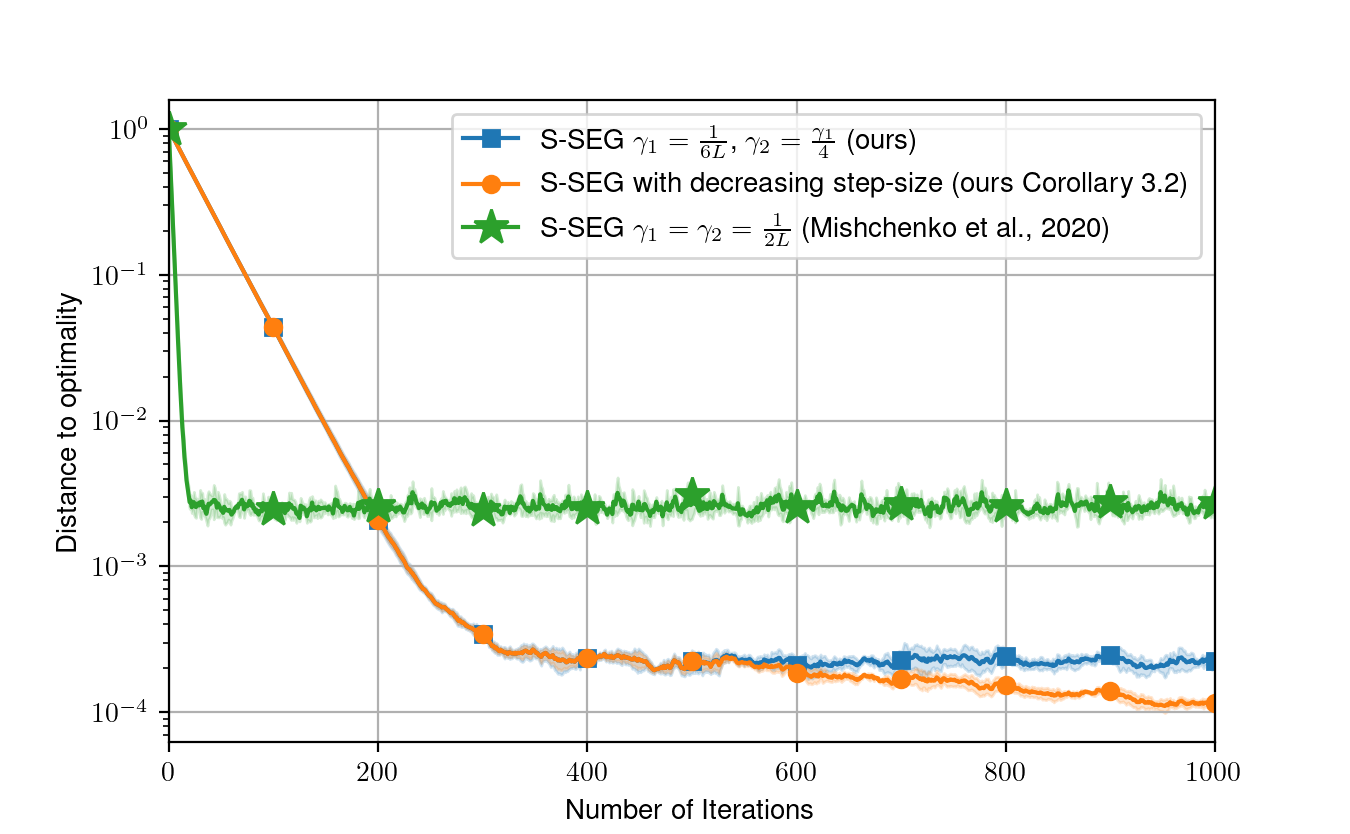

In [50]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-NEW-CONSTANT-1/*.json"), label=r"S-SEG $\gamma_1=\frac{1}{6L}$, $\gamma_2=\frac{\gamma_1}{4}$ (ours)", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-NEW-DECREASING-1/*.json"), label=r"S-SEG with decreasing step-size (ours Corollary 3.2)", marker="o", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-KONSTANTIN-1/*.json"), label=r"S-SEG $\gamma_1=\gamma_2=\frac{1}{2L}$ (Mishchenko et al., 2020)", marker="*", normalize=True, markevery=100, markersize=13)
plt.xlim(0, config.K)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/sseg.pdf', bbox_inches='tight')


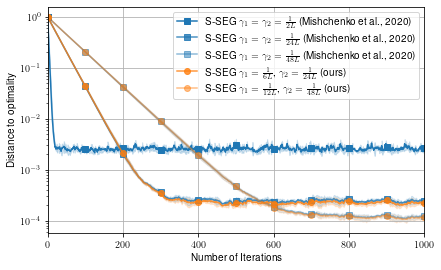

In [204]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-KONSTANTIN-1/*.json"), label=r"S-SEG $\gamma_1=\gamma_2=\frac{1}{2L}$ (Mishchenko et al., 2020)", alpha=1., color="tab:blue", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-KONSTANTIN-24/*.json"), label=r"S-SEG $\gamma_1=\gamma_2=\frac{1}{24L}$ (Mishchenko et al., 2020)", alpha=0.8, color="tab:blue", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-KONSTANTIN-48/*.json"), label=r"S-SEG $\gamma_1=\gamma_2=\frac{1}{48L}$ (Mishchenko et al., 2020)", alpha=0.5, color="tab:blue", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-NEW-CONSTANT-1/*.json"), label=r"S-SEG $\gamma_1=\frac{1}{6L}$, $\gamma_2=\frac{1}{24L}$ (ours)", alpha=0.8, color="tab:orange", marker="o", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-NEW-CONSTANT-2/*.json"), label=r"S-SEG $\gamma_1=\frac{1}{12L}$, $\gamma_2=\frac{1}{48L}$ (ours)", alpha=0.5, color="tab:orange", marker="o", normalize=True, markevery=100)
plt.xlim(0, 1000)
plt.grid()
plt.legend(loc="upper right")
plt.savefig('aistats_2022/figures/sseg_constant_vs_konstantin.pdf', bbox_inches='tight')


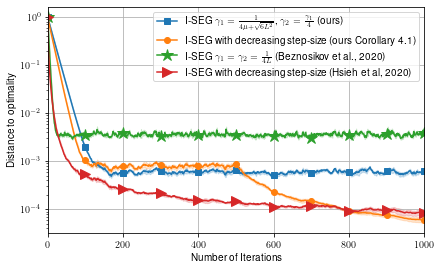

In [200]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "I-SEG-NEW-CONSTANT-1/*.json"), label=r"I-SEG $\gamma_1=\frac{1}{4\mu + \sqrt{6L^2}}$, $\gamma_2=\frac{\gamma_1}{4}$ (ours)", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "I-SEG-OLD-DECREASING-1/*.json"), label=r"I-SEG with decreasing step-size (ours Corollary 4.1)", marker="o", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "I-SEG-ALEKSANDER-1/*.json"), label=r"I-SEG $\gamma_1=\gamma_2=\frac{1}{4L}$ (Beznosikov et al., 2020)", marker="*", normalize=True, markevery=100, markersize=13)
plot(os.path.join(config.log_dir, "I-SEG-HSIEH-1/*.json"), label=r"I-SEG with decreasing step-size (Hsieh et al, 2020)", marker=">", normalize=True, markevery=100, markersize=10)
plt.xlim(0, 1000)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/iseg.pdf', bbox_inches='tight')


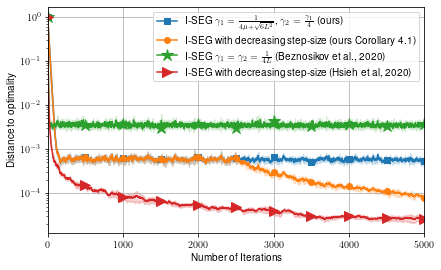

In [194]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "I-SEG-NEW-CONSTANT-K5000/*.json"), label=r"I-SEG $\gamma_1=\frac{1}{4\mu + \sqrt{6L^2}}$, $\gamma_2=\frac{\gamma_1}{4}$ (ours)", marker="s", normalize=True, markevery=500)
plot(os.path.join(config.log_dir, "I-SEG-NEW-DECREASING-K5000/*.json"), label=r"I-SEG with decreasing step-size (ours Corollary 4.1)", marker="o", normalize=True, markevery=500)
plot(os.path.join(config.log_dir, "I-SEG-ALEKSANDER-K5000/*.json"), label=r"I-SEG $\gamma_1=\gamma_2=\frac{1}{4L}$ (Beznosikov et al., 2020)", marker="*", normalize=True, markevery=500, markersize=13)
plot(os.path.join(config.log_dir, "I-SEG-HSIEH-K5000/*.json"), label=r"I-SEG with decreasing step-size (Hsieh et al, 2020)", marker=">", normalize=True, markevery=500, markersize=10)
plt.xlim(0, 5000)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/iseg_K5000.pdf', bbox_inches='tight')


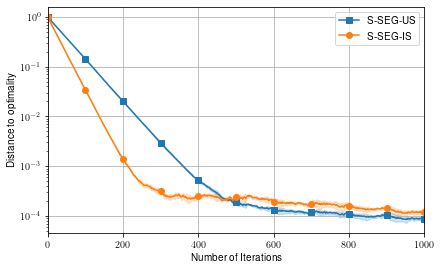

In [141]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-US-2/*.json"), label=r"S-SEG-US", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-IS-2/*.json"), label=r"S-SEG-IS", marker="o", normalize=True, markevery=100)
plt.xlim(0, config.K)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/us_vs_is_2.pdf', bbox_inches='tight')

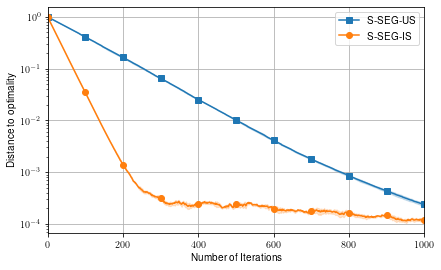

In [135]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-US-5/*.json"), label=r"S-SEG-US", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-IS-5/*.json"), label=r"S-SEG-IS", marker="o", normalize=True, markevery=100)
plt.xlim(0, config.K)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/us_vs_is_5.pdf', bbox_inches='tight')

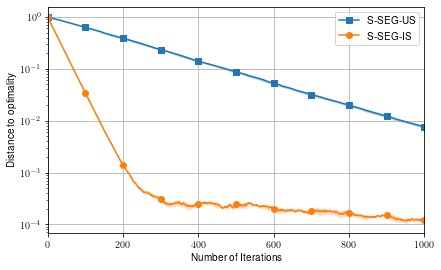

In [136]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-US-10/*.json"), label=r"S-SEG-US", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-IS-10/*.json"), label=r"S-SEG-IS", marker="o", normalize=True, markevery=100)
plt.xlim(0, config.K)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/us_vs_is_10.pdf', bbox_inches='tight')

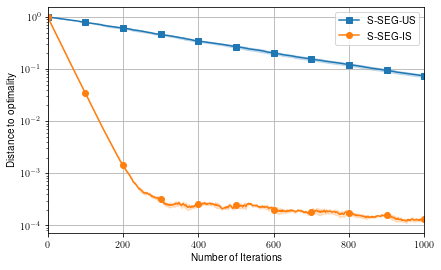

In [137]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-US-20/*.json"), label=r"S-SEG-US", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-IS-20/*.json"), label=r"S-SEG-IS", marker="o", normalize=True, markevery=100)
plt.xlim(0, config.K)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/us_vs_is_20.pdf', bbox_inches='tight')

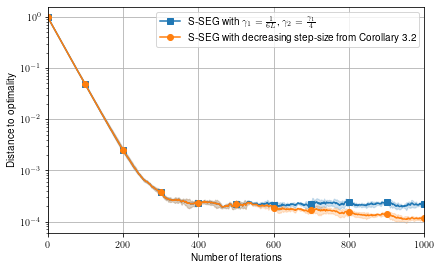

In [199]:
plt.figure(figsize=set_size(width))
plot(os.path.join(config.log_dir, "S-SEG-CONSTANT-NEGATIVE/*.json"), label=r"S-SEG with $\gamma_1=\frac{1}{6L}$, $\gamma_2=\frac{\gamma_1}{4}$", marker="s", normalize=True, markevery=100)
plot(os.path.join(config.log_dir, "S-SEG-DECREASING-NEGATIVE/*.json"), label=r"S-SEG with decreasing step-size from Corollary 3.2", marker="o", normalize=True, markevery=100)
plt.xlim(0, config.K)
plt.grid()
plt.legend()
plt.savefig('aistats_2022/figures/negative_mu.pdf', bbox_inches='tight')